<a href="https://colab.research.google.com/github/MalikHasnat1999/ZTM_Tensorflow/blob/master/04_Transfer_Learning_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import tensorflow_hub as hub
from tensorflow.keras import layers

# Transfer Learning Part-I : Feature Extraction

> Transfer Learning is leveraging a working model's existing arvhitecture and learn patterns for our own problem

# Import the data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-08-17 16:08:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.0MB/s    in 3.9s    

2021-08-17 16:08:38 (41.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
data = zipfile.ZipFile("10_food_classes_10_percent.zip")
data.extractall()
data.close

<bound method ZipFile.close of <zipfile.ZipFile filename='10_food_classes_10_percent.zip' mode='r'>>

In [ ]:
# Walk throught the dataset
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(filenames)} images in '{dirpath}'")

There are 0 images in '10_food_classes_10_percent'
There are 0 images in '10_food_classes_10_percent/train'
There are 75 images in '10_food_classes_10_percent/train/steak'
There are 75 images in '10_food_classes_10_percent/train/ramen'
There are 75 images in '10_food_classes_10_percent/train/fried_rice'
There are 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 75 images in '10_food_classes_10_percent/train/pizza'
There are 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 75 images in '10_food_classes_10_percent/train/hamburger'
There are 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 images in '10_food_classes_10_percent/test'
There are 250 images in '10_food_classes_10_percent/test/steak'
There are 250 images in '10_food_classes_10_percent/test/ramen'
There are 250 images in '10_fo

# Create Data Loader (preparing the data)

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Data")
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing Data")
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=TARGET_SIZE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training Data
Found 750 images belonging to 10 classes.
Testing Data
Found 2500 images belonging to 10 classes.


# Setting up callbacks


callbacks are Extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking Experiments with the **Tensorboard** callback
* Model checkpoint with the **ModelCheckpoint** callback
* Stopping model from training (before it trains too long and overfits) with the **EarlyStopping** callback

In [ ]:
# Create Tensorboard callbacks (functionized cause we need to created one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  LOG_DIR = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime('%d%m%y-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)
  print(f"Saving the Tensorboard log files to {LOG_DIR}")
  
  return tensorboard_callback

**NOTE:** you can customize the directory where your Tensorboard log get saved to where ever you like

The `LOG_DIR` paremeter that we have created is only one option.

# Creating models using Tensorflow Hub

In the past we have used Tensorflow to create our own models layer by layer from scratch.

Now we are going to do a similar procecss, except the majority of our model's layers are going to come from  Tensorflow Hub

We can access pretrained model on: https://tfhub.dev



In [ ]:
# Lets compare the two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [ ]:

def create_model(model_url, num_classes=10):
  """
  Args:
    model_url(str): A Tensorflow Hub feature extraction url.
    num_classes(int): Number of output neurons in the output layer, 
                      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled keras Sequential model with model url as feature extractor
    layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="Feature_Extraction_Layer",
                                           input_shape=TARGET_SIZE+(3,))
  # Create our own model
  model = tf.keras.Sequential([
              feature_extractor_layer,
              layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

## 143.Create and Test ResNet Tensorflow Hub Feature Extractor model

In [ ]:
resnet_model = create_model(resnet_url)

In [ ]:
# Compile the model
resnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# fit the model
resnet_history = resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow hub",
                                                        experiment_name="resnet50v2")])

Saving the Tensorboard log files to tensorflow hub/resnet50v2/170821-160854
Epoch 1/5
24/24 [==============================] - 57s 1s/step - loss: 2.0689 - accuracy: 0.3107 - val_loss: 1.2662 - val_accuracy: 0.6012
Epoch 2/5
24/24 [==============================] - 21s 913ms/step - loss: 0.9555 - accuracy: 0.7227 - val_loss: 0.9044 - val_accuracy: 0.7016
Epoch 3/5
24/24 [==============================] - 21s 908ms/step - loss: 0.6424 - accuracy: 0.8187 - val_loss: 0.7716 - val_accuracy: 0.7532
Epoch 4/5
24/24 [==============================] - 21s 901ms/step - loss: 0.4872 - accuracy: 0.8773 - val_loss: 0.7232 - val_accuracy: 0.7664
Epoch 5/5
24/24 [==============================] - 21s 910ms/step - loss: 0.3989 - accuracy: 0.8947 - val_loss: 0.6840 - val_accuracy: 0.7748


In [ ]:
 resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_Extraction_Layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## plot_loss_curve()

In [ ]:
# Training loss curve
def plot_loss_curve(history):
  """
  Return seprate loss curve for training and validation metrics.

  Args:
    history: Tensorflow History object

  Returns:
    Plots of training loss curve
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # plot loss
  plt.figure()
  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss Curve")
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy Curve")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend()

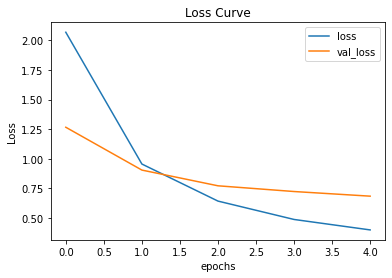

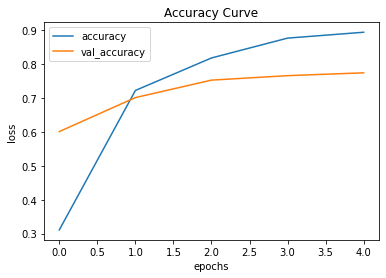

In [ ]:
plot_loss_curve(resnet_history)

## 145.Create and Test EfficientNetB0 Feature Extraction model

In [ ]:
def create_model_2(model_url, num_classes=10):
  """
  Args:
  model_url(str): A Tensorflow Hub Feature Extraction url.
  num_classes(int): Number of output neurons in output layer

  Returns:
    An uncompiled Keras Sequential model with model url as feature extractor layer
    and Dense output layer with num_classes outputs
  """
  feature_extractor_layer = hub.KerasLayer(model_url,
                                     trainable=False,
                                     name="Feature_Extraction_layer",
                                     input_shape=TARGET_SIZE+(3,))

  model = tf.keras.Sequential([
            feature_extractor_layer,
            tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [ ]:
# create model
efficientnet_model = create_model_2(efficientnet_url)

In [ ]:
# compile the model
efficientnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                     epochs=5, 
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data,
                                     validation_steps=len(test_data),
                                     callbacks=[create_tensorboard_callback(dir_name="tensorflow hub",
                                                                            experiment_name="efficientnetb0")])

Saving the Tensorboard log files to tensorflow hub/efficientnetb0/170821-161123
Epoch 1/5
24/24 [==============================] - 26s 934ms/step - loss: 1.8466 - accuracy: 0.4013 - val_loss: 1.3128 - val_accuracy: 0.7412
Epoch 2/5
24/24 [==============================] - 19s 802ms/step - loss: 1.0534 - accuracy: 0.7907 - val_loss: 0.8670 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 19s 796ms/step - loss: 0.7465 - accuracy: 0.8413 - val_loss: 0.6977 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 19s 795ms/step - loss: 0.6011 - accuracy: 0.8640 - val_loss: 0.6135 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 19s 811ms/step - loss: 0.5095 - accuracy: 0.8867 - val_loss: 0.5618 - val_accuracy: 0.8612


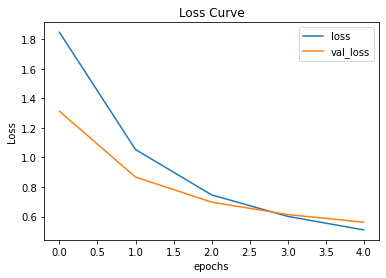

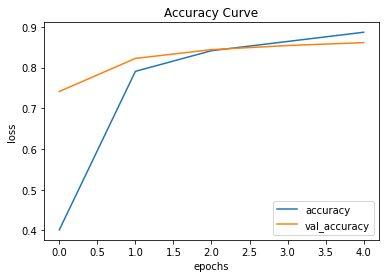

In [ ]:
# create loss curve
plot_loss_curve(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_Extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_Extraction_Layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


# Different types of Transfer Learning 

As is "Transfer Learning" - using existential model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes)

**"feature extraction"** transfer learning - use the prelearned patterns of existing model (e.g EfficientNetb0 trained on ImageNet) and adjust the output layer of your own problem


**"fine tuning"** transfer learning - use the prelearned patterens of an an existing model and "fine-tune" many or all underlying layers

# Comparing our results using TensorBoard

In [ ]:
# Upload Tensorboard dev records
! tensorboard dev upload --logdir ./'tensorflow hub'/ \
  --name "EfficientNetb0 vs ResNet50V2" \
  --description "Comparing two tensorflow hub feature extraction models" \
  --one_shot

2021-08-17 16:13:37.651515: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

## List TensorBoard Dev List

In [ ]:
! tensorboard dev list

2021-08-17 16:15:18.324612: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/xaZ1k8FgQ3quKhoWSq1C3w/
	Name                 EfficientNetb0 vs ResNet50V2
	Description          Comparing two tensorflow hub feature extraction models
	Id                   xaZ1k8FgQ3quKhoWSq1C3w
	Created              2021-08-17 16:14:16 (1 minute ago)
	Updated              2021-08-17 16:14:20 (1 minute ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3389175
Total: 1 experiment(s)


## Delete an Experiment

In [ ]:
# ! tensorboard dev delete --experiment_id xaZ1k8FgQ3quKhoWSq1C3w

# **Exercise**

In [ ]:
import tensorflow as tf
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import datetime
import tensorflow_hub as hub
import matplotlib.pyplot as plt


## Q-1

Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction [(mobilenet_v2_100_224/feature_vector)](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4) from TensorFlow Hub, how does it perform compared to our other models?

In [ ]:
# import the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-08-18 07:45:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  42.1MB/s    in 3.8s    

2021-08-18 07:45:23 (42.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Unzip the file
zip_ref = zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/10_food_classes_10_percent.zip' mode='r'>>

In [ ]:
# preprocess the data (prepare data loader)
train_dir = "/content/10_food_classes_10_percent/train" 
test_dir = "/content/10_food_classes_10_percent/test"

BATCH_SIZE=32
TARGET_SIZE=(224, 224)

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=TARGET_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=BATCH_SIZE,
                                             target_size=TARGET_SIZE,
                                             class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
# Walk through the directories

for dirpath, dirnames, filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"There are {len(filenames)} images in '{dirpath}'")

There are 0 images in '/content/10_food_classes_10_percent'
There are 0 images in '/content/10_food_classes_10_percent/train'
There are 75 images in '/content/10_food_classes_10_percent/train/hamburger'
There are 75 images in '/content/10_food_classes_10_percent/train/chicken_curry'
There are 75 images in '/content/10_food_classes_10_percent/train/fried_rice'
There are 75 images in '/content/10_food_classes_10_percent/train/ice_cream'
There are 75 images in '/content/10_food_classes_10_percent/train/ramen'
There are 75 images in '/content/10_food_classes_10_percent/train/steak'
There are 75 images in '/content/10_food_classes_10_percent/train/sushi'
There are 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'
There are 75 images in '/content/10_food_classes_10_percent/train/pizza'
There are 75 images in '/content/10_food_classes_10_percent/train/grilled_salmon'
There are 0 images in '/content/10_food_classes_10_percent/test'
There are 250 images in '/content/10_food

In [ ]:
# Create Tensorboard Callback

def tensorboard_callback(dir_name, experiment_name):
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
                  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  ) 

  return tensorboard_callback

In [ ]:
# creating path object the model
mobilenet = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

In [ ]:
def create_model_2(model_url, num_classes=10):
  # download the model as a Sequential model layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           input_shape=TARGET_SIZE+(3,),
                                           name="Feature_Extraction_Layer")
  # create the model
  model = tf.keras.Sequential([
              feature_extractor_layer,
              tf.keras.layers.Dense(10, activation="softmax", name="output_layer")
  ])

  # return the model
  return model

In [ ]:
# create the model
mobilenet_model = create_model_2(mobilenet)

In [ ]:
# compile the model
mobilenet_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# fit the model
mobilenet_history = mobilenet_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[tensorboard_callback("Exercise_TensorBoard_Hub",
                                                                       "MobileNet_V2_100_224",)])

Epoch 1/5
24/24 [==============================] - 58s 1s/step - loss: 1.9333 - accuracy: 0.3533 - val_loss: 1.2498 - val_accuracy: 0.6368
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0268 - accuracy: 0.6973 - val_loss: 0.8493 - val_accuracy: 0.7596
Epoch 3/5
24/24 [==============================] - 18s 775ms/step - loss: 0.7213 - accuracy: 0.7960 - val_loss: 0.7139 - val_accuracy: 0.7904
Epoch 4/5
24/24 [==============================] - 18s 779ms/step - loss: 0.5611 - accuracy: 0.8613 - val_loss: 0.6538 - val_accuracy: 0.8008
Epoch 5/5
24/24 [==============================] - 18s 775ms/step - loss: 0.4702 - accuracy: 0.9000 - val_loss: 0.6198 - val_accuracy: 0.8052


In [ ]:
# Create Training Loss Curve
def plot_loss_curve_2(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy =  history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  # plot the graphs
  plt.figure()
  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss Curve")
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy Curve")
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.legend()

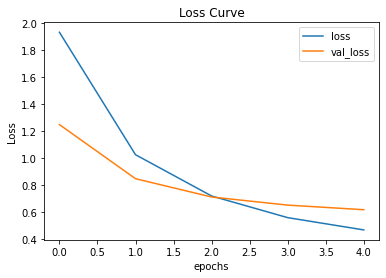

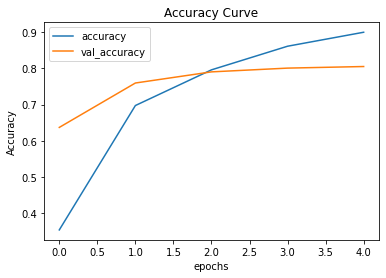

In [ ]:
plot_loss_curve_2(mobilenet_history)

In [ ]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_Extraction_Layer (Ke (None, 1280)              2257984   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
resnet_model.summary()

NameError: ignored

In [ ]:
efficientnet_model.summary()

NameError: ignored

## Q-2
Name 3 different image classification models on TensorFlow Hub that we haven't used.

>  **(VGG-16)** Very Deep Convolutional Networks for Large-Scale Image Recognition 

> Inceptionv3


## Q-4

What is the current best performing model on ImageNet?

> ResNeXt-101 32x48d

